In [4]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Two sample testing

In many applications there is an interest in comparing two random samples; for example, investigating differences in cholesterol levels between two groups of patients. It is often done using a hypothesis test - hence the name "**two sample testing**". This is also called **A/B testing**.

The natural hypotheses for this situation are:

$H_0$: the two samples are generated from the same distribution.

$H_A$: the two samples are generated from two different distributions.

The test statistic is normally based on the difference in a specified sample summary; for example, difference in means, or medians, or standard deviations (if we expect the sample to differ in their variability). 

We illustrate this with a [classic diabetes dataset](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database) from the National Institute of Diabetes and Digestive and Kidney Diseases. The subjects of this dataset are females at least 21 years old, and the goal was to predict diabetes status that is summarized in the column called "Outcome".

In [6]:
diabetes=pd.read_csv("../../data/diabetes.csv")
diabetes.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


We will focus in this example on BMI. Below are **boxplots** for the two diabetes status groups.

:::{note}

A boxplot (also commonly known as a box and whisker plot) is a great choice to help visualize and compare the distribution of data within one or more groups. Although a boxplot might seem confusing the first time you see it, all of its components help us to quickly understand important summary statistics of the data distribution.

The bottom edge of the box demarcates the 25th percentile (Quartile 1, or Q1) of the data. The top edge of the box demarcates the 75th percentile (Quartile 3, or Q3). Thus, the box itself represents the range in which the middle 50% of the data falls (Q3-Q1). This range is also commonly referred to as the **Interquartile Range (IQR)**.

The horizontal line within the box indicates the median value of the distribution (50th percentile). When using the `matplotlib.boxplot()` function, the top whisker (what looks like a T above the box) extends to the largest data point of the distribution that falls within the range $Q3 + 1.5*IQR$. The bottom whisker (what looks like an upside down T below the box) extends to the smallest data point within the range $Q1 - 1.5*IQR$. Data points with a value larger or lower than the whiskers are considered outliers and represented as circles above or below the whiskers.

:::

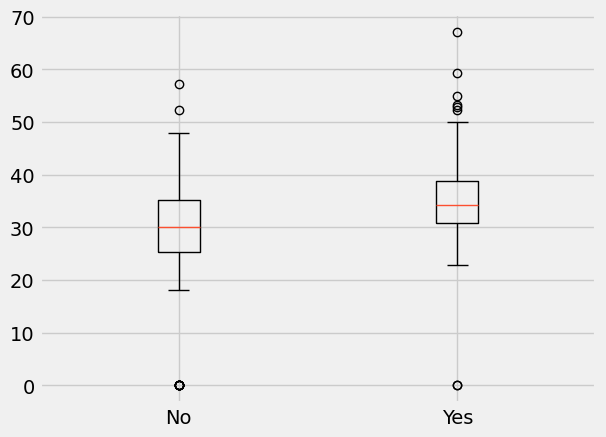

In [12]:
plt.boxplot([diabetes.BMI[diabetes.Outcome==0],
             diabetes.BMI[diabetes.Outcome==1]],
            tick_labels=["No","Yes"]);

There are several observations from the above plots: 
- The distributions of BMI in the two groups seem different; for example, the median BMI is larger in diabetics.
- There are some subjects for which the recorded value for BMI is equal to 0; this suggests that missing data were recorded as 0 (as a BMI of 0 is biologically implausible!) and we will have to take that into account in our analysis.

Below, we create two arrays that contain the BMI values in the two groups after removing the missing data.

In [17]:
# remove missing data
d_no=diabetes.BMI[(diabetes.Outcome==0)&(diabetes.BMI>0)]
d_yes=diabetes.BMI[(diabetes.Outcome==1)&(diabetes.BMI>0)]

n0=len(d_no)
n1=len(d_yes)

print([n0,n1])

[491, 266]


We have two samples here of size $n_0=491$ and $n_1=266$, and the null hypothesis we investigate is:  BMI distributions in diabetics and non-diabetics subjects are the same. 

The test statistic we will use is the difference in sample medians, with an observed value of 4.2:

In [ ]:
test_stat=np.median(d_yes)-np.median(d_no)
print(round(test_stat,2))

The next step is to obtain an approximation for the sampling distribution of our test statistic. The procedure we implement, called a **permutation test**, uses the following observations:
- If the null hypothesis is true: a BMI value is equally likely to be sampled from diabetics and non-diabetics.
- If the null hypothesis is true: all rearrangements (permutations) of BMI values among the two groups are equally likely.
- If the null hypothesis is true: the observed test statistic can be viewed as a sample from the distribution of median differences of permuted BMI values in two groups.

It suggests the following simulation to learn the null distribution for the test statistic:
- Shuffle (permute) the BMI values
- Assign $n_0=491$ to “Group A“ and the rest to “Group B“ (to maintain the two sample sizes)
- Find the differences between medians of the two shuffled (permuted) groups
- Repeat

The generated distribution and the value of the test statistic are used to calculate a p-value.

We first illustrate how to create shuffled samples and calculate the corresponding test statistic. We use the numpy function `np.random.permutation()` to create an array that has the same values but with order that is shuffled: the first part of the new array will correspond to the control group. 

In [ ]:
shuffled_combine=np.random.permutation(np.append(d_no,d_yes))
shuffled_no=shuffled_combine[0:n0]
shuffled_yes=shuffled_combine[n0:(n0+n1)]

np.median(shuffled_yes)-np.median(shuffled_no)

In the cell code below, we repeat the procedure 5,000 times and create an approximation for the distribution of our test statistic that is saved in the array `differences`.

In [ ]:
differences = np.array([])

for i in np.arange(5000):
    shuffled_combine=np.random.permutation(np.append(d_no,d_yes))
    shuffled_no=shuffled_combine[0:n0]
    shuffled_yes=shuffled_combine[n0:(n0+n1)]
    differences = np.append(differences,np.median(shuffled_yes)-np.median(shuffled_no))

In [ ]:
plt.hist(differences)
plt.scatter(test_stat, -20, color='red', s=30)
plt.title('5000 simulated datasets')
plt.xlabel("Difference in medians");

From the above histogram, we can see that there is strong evidence against the null hypothesis that the distributions of BMI in cases and controls are the same.

Please note that the choice of test statistic could have a big impact on the conclusions from the test. Below, we repeat the procedure using as test statistic the difference in standard deviations of the two samples. There is no evidence that the distributions are different when using this statistic.

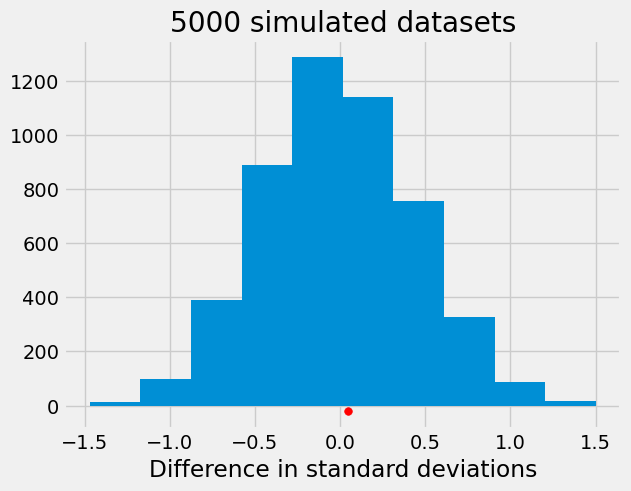

In [19]:
differences = np.array([])

# define group sample sizes
group_a = 491
group_b = 266

for i in np.arange(5000):
    shuffled_combine=np.random.permutation(np.append(d_no,d_yes))
    shuffled_no=shuffled_combine[0:group_a]
    shuffled_yes=shuffled_combine[group_a:(group_a+group_b)]
    differences = np.append(differences,np.std(shuffled_yes)-np.std(shuffled_no))


plt.hist(differences)
plt.scatter(np.std(d_yes)-np.std(d_no), -20, color='red', s=30)
plt.title('5000 simulated datasets')
plt.xlabel("Difference in standard deviations");